In [62]:
import numpy as np
from osgeo import gdal
from PIL import Image
import glob

from d22_utils import get_extent, get_query_bbox, add_colorbar, print_info

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib import gridspec

from copy import deepcopy

In [63]:
# Load query bounding box
query_bbox = get_query_bbox("bolzano.geojson")

In [68]:
# Select data
data_type = 'L1C' # 'L1C or L2A'

filepaths = sorted(glob.glob(f"results/min-evi*_{data_type}.*"))
print(filepaths)

['results/min-evi_EODC_L1C.tif', 'results/min-evi_EURAC_L1C.tif', 'results/min-evi_JRC_L1C.tif', 'results/min-evi_Sinergise_L1C.tif', 'results/min-evi_VITO_L1C.tif', 'results/min-evi_WWU_GEE_L1C.png']


In [69]:
# Load data
rasters = {}
for k, item in enumerate(filepaths):
    item_name = item.split('/')[-1].split('_')[1]
    print(item_name)
    if item_name == "WWU":
        item_name = "WWU-GEE"
        rasters[item_name] = {
        'ds': None,
        'data': np.asarray(Image.open(item)).astype(np.float64)
    }
    else:
        rasters[item_name] = {
            'ds': gdal.Open(item),
            'data': gdal.Open(item).ReadAsArray().astype(np.float64)
        }
    if not isinstance(rasters[item_name]['data'], np.float64):
        rasters[item_name]['data'] = rasters[item_name]['data'].astype(np.float64)
    
    # EODC has Inf values, exchange them with NaN
    rasters[item_name]['data'][np.isinf(rasters[item_name]['data'])] = np.nan

EODC
EURAC
JRC
Sinergise
VITO
WWU


In [70]:
# Print some info about raster data
for item in rasters:
    print(item)
    print_info((rasters[item]['data']))

EODC
Raster shape: (678, 961)
Min: -3056.0
Mean: 0.057
Median: 0.071
Max: 0.41
Negative values [%]: 2.4 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


EURAC
Raster shape: (679, 962)
Min: -54612.5
Mean: -0.035
Median: 0.071
Max: 0.777
Negative values [%]: 0.0 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


JRC
Raster shape: (677, 999)
Min: -3056.0
Mean: 0.347
Median: 0.368
Max: 0.921
Negative values [%]: 2.1999999999999997 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


Sinergise
Raster shape: (678, 961)
Min: -3054.765
Mean: 0.057
Median: 0.071
Max: 0.41
Negative values [%]: 2.5 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


VITO
Raster shape: (987, 1488)
Min: -12612.941
Mean: 0.336
Median: 0.363
Max: 0.89
Negative values [%]: 2.1999999999999997 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


WWU-GEE
Ra

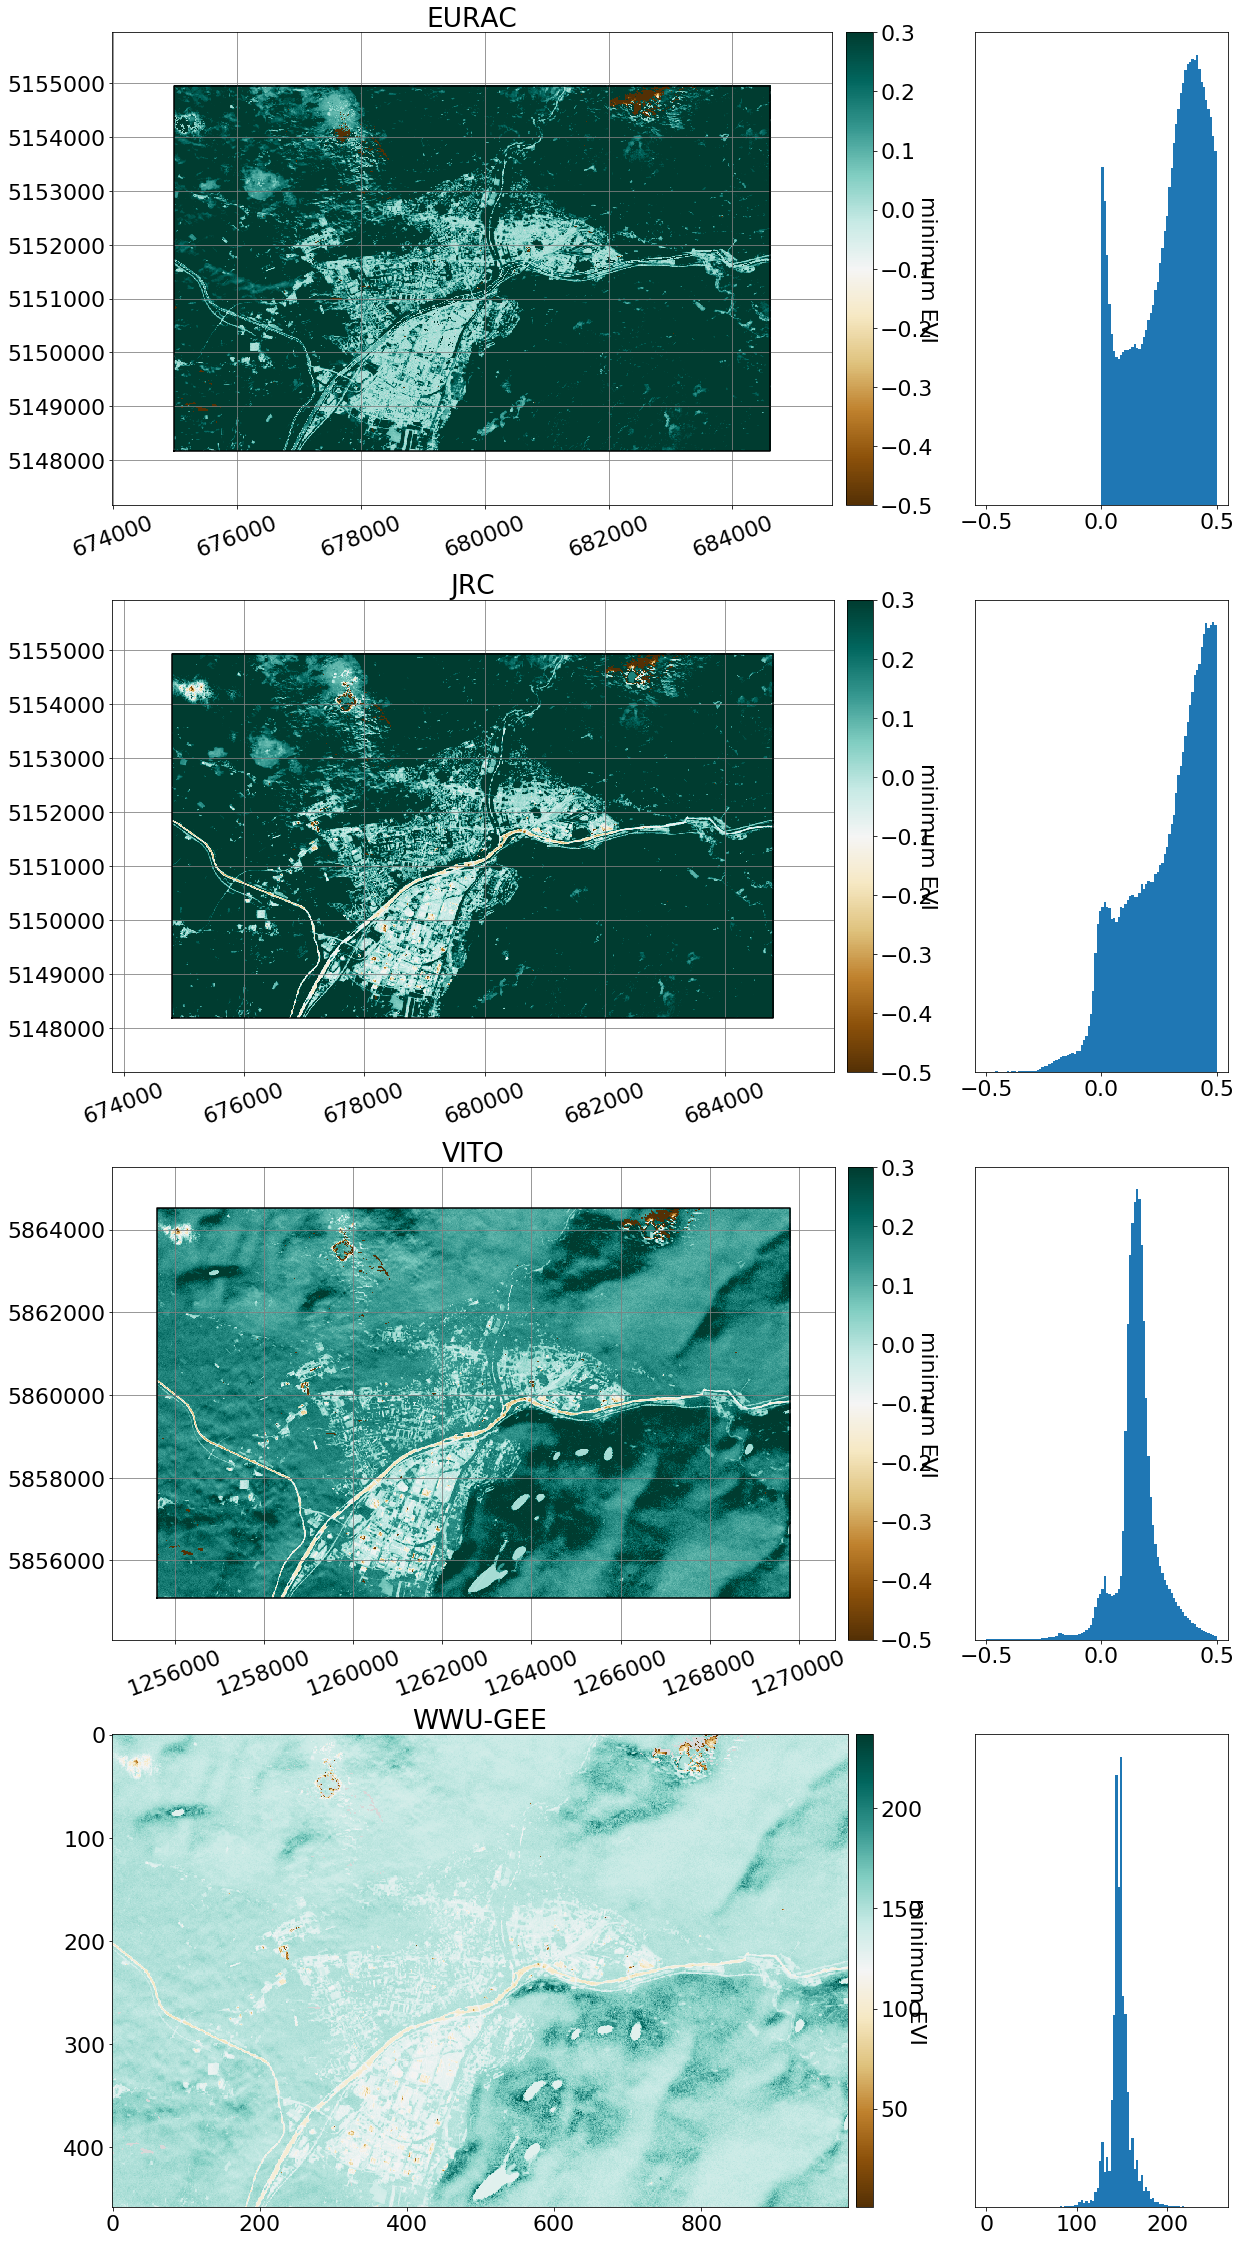

In [67]:
# Make plot

# Create colormap
current_cmap = plt.get_cmap("BrBG")
current_cmap.set_bad(color=[0.85, 0.85, 0.85])


fig = plt.figure(figsize=(20, 10*len(rasters)))
gs = gridspec.GridSpec(len(rasters), 2, width_ratios=[3, 1])
gs.update(wspace=0.2, hspace=0.2)
for k, item in enumerate(rasters):
    ## Create axis for subplot ##
    j = k+k     
    ax1 = plt.subplot(gs[j+1])
    ax2 = plt.subplot(gs[j])
    
    rasters[item]['data'][rasters[item]['data']==0] = np.nan # mostly needed for WWU-GEE
    
    ## Plot map ##
    ## Plot normalized histogram ##
    if rasters[item]['ds'] and rasters[item]['ds'].GetProjection():
        hist_range = (-0.5, 0.5)
    else:
        hist_range = (0, 255)

    N = rasters[item]['data'].shape[0] * rasters[item]['data'].shape[1]
    tmp_data = rasters[item]['data'].reshape(1, N).flatten()
    tmp_data[tmp_data == -np.inf] = -9999
    tmp_data[np.isnan(tmp_data)] = -9999
    im = ax1.hist(tmp_data, bins=100, range=hist_range, density=True)
    ax1.get_yaxis().set_ticks([]) # no y ticks
    
    ## Plot map ##
    subplot_title = item.replace('sinergise', 'Sinergise')
    ax2.set_title(subplot_title)
    v_min = -0.5
    v_max = 0.3
    if rasters[item]['ds'] and rasters[item]['ds'].GetProjection():
        if item == 'Sinergise':
            raster_extent, raster_bbox = get_extent(rasters[item]['ds'], geographic=True)
            offset = 0.01 # degrees
        else:
            raster_extent, raster_bbox = get_extent(rasters[item]['ds'])
            offset = 1000 # meters
        im = ax2.imshow(rasters[item]['data'], cmap=current_cmap, vmin=v_min, vmax=v_max, aspect='auto', extent=raster_extent)
        plt.xticks(rotation=20)

        ## Add bounding boxes ##
        ax2.plot(raster_bbox[0], raster_bbox[1], 'k') # raster bbox

        # Add grid lines
        ax2.grid(b=True, which='major', color='gray', linestyle='-')
        
        # Make axis slightly larger
        ax2.set_xlim(raster_extent[0]-offset, raster_extent[1]+offset)
        ax2.set_ylim(raster_extent[2]-offset, raster_extent[3]+offset)
    else:
        # WWU-GEE is not georeferenced
        im = ax2.imshow(rasters[item]['data'], cmap=current_cmap, aspect='auto')

    im = add_colorbar(im)
    
    del(ax1, ax2)
    
 
fig.savefig(f'comparison_output/comparison_min-evi_{data_type}.png', bbox_inches='tight')